## Overview
In this notebook, a draft of balanced graph partitioning strategies along with utils functions are stored.
For testing FB15k-237 dataset was used.

Specifically:
- Utilities functions for measuring time and memory usage of functions implemented as decorators.
- Class hierarchy for graph partitioning: AbstractGraphPartitioner and derived classes of RandomVerticesGraphPartitioner and RandomEdgesGraphPartitioner.
- Utility class for assesing the quality of the partitionings called QualityReporter, which calculates the following metrics: edge cut, edge and vertex imbalances, time and memory used. 

#### Imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import ampligraph as amp
from ampligraph import datasets
import tracemalloc
from time import time
import pytest
from abc import ABC, abstractmethod
from functools import wraps

#### Time & Memory Functions

In [16]:
def get_memory_size():
    """Get memory size.
    
    Returns
    -------
    total: memory size in usage in total
    """
    snapshot = tracemalloc.take_snapshot()
    stats = snapshot.statistics('lineno', cumulative=True)
    total = sum(stat.size for stat in stats)
    return total

def get_human_readable_size(size_in_bytes):
    """Convert size in bytes in human readable units.
    
    Parameters
    ----------
    size_in_bytes: original size given in bytes
    
    Returns
    -------
    tuple of new size and unit, size in units GB/MB/KB/Bytes according to thresholds.
    """
    if size_in_bytes >= 1024*1024*1024:
        return float(size_in_bytes/(1024*1024*1024)), "GB" # return in GB
    if size_in_bytes >= 1024*1024:
        return float(size_in_bytes/(1024*1024)), "MB" # return in MB
    if size_in_bytes >= 1024:
        return float(size_in_bytes/1024), "KB" # return in KB
    return float(size_in_bytes), "Bytes"    

def timing_and_memory(f):
    """Decorator to register time and memory used by a function f.
    
    Parameters
    ----------
    f: function for which the time an memory will be measured
    
    It logs the time and the memory in the dictionary passed inside 'log' parameter if provided.
    Time is logged in seconds, memory in bytes. Example dictionary entry looks like that:
    {'SPLIT':{'time':1.62, 'memory-bytes':789.097}}, where keys are names of functions that 
    were called to get the time measured in uppercase.
    """
    @wraps(f)
    def wrapper(*args, **kwargs):
        tracemalloc.start()
        mem_before = get_memory_size()
        start = time()
        result = f(*args, **kwargs)
        end = time()
        mem_after = get_memory_size()
        mem_diff = mem_after - mem_before
        print("{}: memory before: {:.5}{}, after: {:.5}{}, consumed: {:.5}{}; exec time: {:.5}s".format(
            f.__name__,
            *get_human_readable_size(mem_before), *get_human_readable_size(mem_after), *get_human_readable_size(mem_diff), end-start))        
        
        if 'log' in kwargs:
            name = kwargs.get('log_name', f.__name__.upper())
            kwargs['log'][name] = {'time': end - start, 'memory-bytes': mem_diff}
        return result
    return wrapper

#### Quality of partitionings assessment

In [17]:
class QualityReporter:
    """Assesses the quality of partitioning according to 
    chosen metrics and report it.
    
    Available metrics: edge cut, edge imbalance, vertex imbalance, time, memory usage.
    
    Parameters
    ----------
    partitionings: data splits to be compared
    
    Example
    -------
    
    >>>>quality = QualityReporter(partitionings)
    >>>>report = quality.report(visualize=False)
    """
    def __init__(self, partitionings):
        self.partitionings = partitionings
    
    def get_edge_cut(self, k, partitions, avg_size=None):
        """Calculates mean edge cut across partitions in a single 
        partitioning.
        
        Parameters
        ----------
        k: number of partitions
        partitions: partitions in one partitioning
        
        Returns
        -------
        
        edge_cut: average edge cut between partitions"""

        intersections = []
        for i in range(k):
            tmp = []
            for j in range(k):
                tmp.append(len(np.intersect1d(partitions[i], partitions[j])))
            intersections.append(np.mean(tmp))

        edge_cut = np.mean(intersections)
        edge_cut_proportion = None
        if avg_size:
            edge_cut_proportion = (edge_cut*100)/avg_size # edge cut with respect to the average partition size
        return edge_cut, edge_cut_proportion
    
    def get_edge_imbalance(self, avg_size, max_size):
        """Calculates edge imbalance of partitions
        
        Parameters
        ----------
        avg_size: average size of partition
        max_size: maximum size of partition
        
        Returns
        -------
        edge_imb: edge imbalance
        """
        
        edge_imb = max_size/avg_size - 1
        return edge_imb
    
    def get_vertex_imbalance(self, partitions):
        """Calculates vertex imbalance of partitions
        
        Parameters
        ----------
        partitions: partitions in one partitioning
        
        Returns
        -------
        vertex_imb: vertex imbalance
        """
        lengths = []
        for partition in partitions:
            lengths.append(len(np.asarray(list(set(partition[:,0]).union(set(partition[:,2]))))))
        
        vertex_imb = np.max(lengths)/np.mean(lengths) - 1
        return vertex_imb
        
    def get_modularity(self):
        """Calculates modularity of partitions.
                
        Parameters
        ----------
        
        Returns
        -------
        modularity: modularity
        """
        raise NotImplementedError       
        
    def report_single_partitioning(self, partitioning, EDGE_CUT=True, \
                                   EDGE_IMB=True, VERTEX_IMB=True):
        """Calculate different metrics for a single partition.
        
        Parameters
        ----------
        partitioning: single split of data into partitions
        EDGE_CUT [True/False]: flag whether to calculate edge cut or not
        EDGE_IMB [True/False]: flag whether to calculate edge imbalance or not
        VERTEX_IMB [True/False]: flag whether to calculate vertex imbalance or not        
        
        Returns
        -------
        metrics: dictionary with metrics
        """
        logs = partitioning[1]
        partitioning = partitioning[0]
        k = len(partitioning)
        sizes = [len(x) for x in partitioning]
        avg_size = np.mean(sizes)
        max_size = np.max(sizes)        
        metrics = {"EDGE_IMB": None, "VERTEX_IMB": None, "EDGE_CUT": None}
        
        if logs:
            metrics["PARTITIONING TIME"] = logs["SPLIT"]['time']
            metrics["PARTITIONING MEMORY"] = logs["SPLIT"]['memory-bytes']
        if EDGE_CUT:
            edge_cut, edge_cut_proportion = self.get_edge_cut(k, partitioning, avg_size)
            metrics["EDGE_CUT"] = edge_cut
            metrics["EDGE_CUT_PERCENTAGE"] = edge_cut_proportion            
        if EDGE_IMB:
            edge_imb = self.get_edge_imbalance(avg_size, max_size)
            metrics["EDGE_IMB"] = edge_imb
        if VERTEX_IMB:
            vertex_imb = self.get_vertex_imbalance(partitioning)
            metrics["VERTEX_IMB"] = vertex_imb              
            
        return metrics
    
    def report(self, visualize=True):
        """Collect individual reports for every partitioning.
        
        Parameters
        ----------
        visualize [True/False] flag indicating whether to visualize output
        
        Returns
        -------
        reports: calculated metrics for all partitionings, dictionary with key 
        as numbers of partitions and values as dictionary with metrics
        """
        reports = {}
        for name, partitioning in self.partitionings.items():
            reports[name] = self.report_single_partitioning(partitioning, EDGE_IMB=True, \
                                                         VERTEX_IMB=True)
            
        if visualize:
            for metric in reports[list(reports.keys())[0]]:
                plot = False
                for report in reports:
                    if reports[report][metric] != None:
                        plt.bar(str(report),reports[report][metric])
                        plot = True
                if plot:
                    plt.title(metric)
                    plt.show()
            
        return reports

In [18]:
class AbstractGraphPartitioner(ABC):
    def __init__(self, data, k=2):
        self._data = data
        self._k = k
            
    def get_triples(self, vertices, **kwargs):
        """Given list of vertices return all triples which contain them.
        
        Parameters
        ----------
        vertices: list of vertices
            
        Returns
        -------
        array with triples containing vertices
            
        """
        return np.array([x for x in self._data if x[2] in vertices \
                         or x[0] in vertices])
            
    @abstractmethod
    def split(self, **kwargs):
        """Split data into k equal size partitions.
           
           Returns
           -------
            partitions: parts of equal size with triples
        """
        pass
    
class RandomVerticesGraphPartitioner(AbstractGraphPartitioner):
    def __init__(self, data, k=2):
        super().__init__(data, k)

    @timing_and_memory
    def split(self, **kwargs):
        """Split data into k equal size partitions by randomly drawing subset of vertices
           of partition size and retrieving triples associated with these vertices.
           
           Returns
           -------
            partitions: parts of equal size with triples
        """
        vertices = np.asarray(list(set(self._data[:,0]).union(set(self._data[:,2]))))
        self.size = len(vertices)
        indexes = range(self.size)
        self.partition_size = int(self.size / self._k)
        vertices_partitions = []
        remaining_data = indexes
        for part in range(self._k):
            split = np.random.choice(indexes, self.partition_size)
            remaining_data = np.setdiff1d(remaining_data, split)
            vertices_partitions.append(self.get_triples(vertices[split]))
        
        return vertices_partitions    
    
class RandomEdgesGraphPartitioner(AbstractGraphPartitioner):
    def __init__(self, data, k=2):
        super().__init__(data, k)

    @timing_and_memory
    def split(self, **kwargs):
        """Split data into k equal size partitions by randomly drawing subset of 
           
           Returns
           -------
            partitions: parts of equal size with triples
        """
        
        self.size = len(self._data)
        indexes = range(self.size)
        self.partition_size = int(self.size / self._k)
        partitions = []
        remaining_data = indexes
        for part in range(self._k):
            split = np.random.choice(indexes, self.partition_size)
            remaining_data = np.setdiff1d(remaining_data, split)
            partitions.append(self._data[split])
        
        return partitions        

### Usage

In [19]:
data = datasets.load_fb15k_237()
sample = data["train"]

In [20]:
partitionings = {}
logs1 = {}
partitioner1 = RandomVerticesGraphPartitioner(sample, k=2)
tmp1 = partitioner1.split(log=logs1)
partitionings['random vertices'] = (tmp1, logs1)
logs2 = {}
partitioner2 = RandomEdgesGraphPartitioner(sample, k=2)
tmp2 = partitioner2.split(log=logs2)
partitionings['random edges'] = (tmp2, logs2)

split: memory before: 880.0Bytes, after: 9.3133MB, consumed: 9.3125MB; exec time: 62.884s
split: memory before: 9.3235MB, after: 15.558MB, consumed: 6.2345MB; exec time: 0.9207s


#### Comparison of partitionings strategies

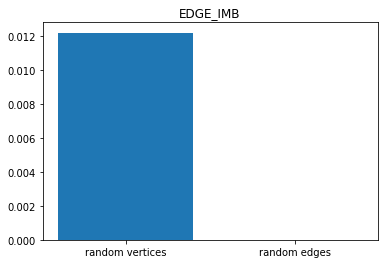

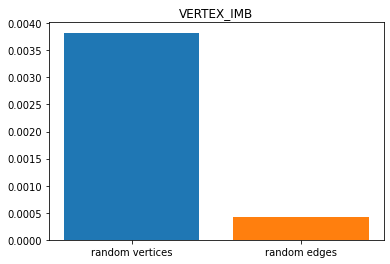

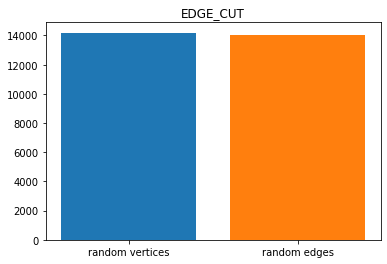

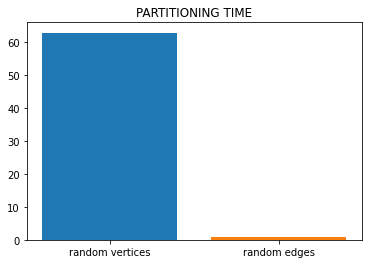

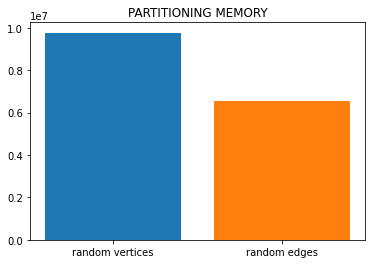

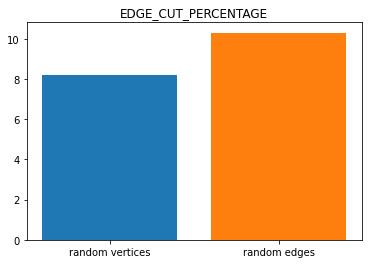

In [21]:
quality = QualityReporter(partitionings)
reports = quality.report()

### Tests:

In [22]:
def test_get_triples_random_vertices():
    vertices = [1]
    data = np.array([[1,2,3],[4,5,1],[1,2,4],[5,2,4]])
    test_data = np.array([[1,2,3],[4,5,1],[1,2,4]])
    graph_partitioner = RandomVerticesGraphPartitioner(data, 2)
    assert (graph_partitioner.get_triples(vertices) == test_data).all()

def test_get_triples_random_edges():
    vertices = [1]
    data = np.array([[1,2,3],[4,5,1],[1,2,4],[5,2,4]])
    test_data = np.array([[1,2,3],[4,5,1],[1,2,4]])
    graph_partitioner = RandomEdgesGraphPartitioner(data, 2)
    assert (graph_partitioner.get_triples(vertices) == test_data).all()    
    
def test_not_equal():
    vertices = [1]    
    data = np.array([[1,2,3],[2,3,4],[3,4,1],[1,1,1],[0,3,2]])    
    test_data = np.array([[1,2,3],[4,5,1],[1,2,4]])
    graph_partitioner = RandomVerticesGraphPartitioner(data, 2)
    assert not (graph_partitioner.get_triples(vertices) == test_data).all()

In [23]:
test_get_triples_random_edges()
test_get_triples_random_vertices()
test_not_equal()